In [1]:
import numpy as np
import matplotlib.pyplot as plt

from propagation import received_power, quad_distribute_power, propagation_delay
from parameter_measurement import aoa_measurement

## Get configuration

**weather and sunlight conditions**

weather-dependent signal attenuation values for laser-based FSO channels are provided in the following paper:

Grabner, M., & Kvicera, V. (2013). "Multiple scattering in rain and fog on free-space optical links." _Journal of lightwave technology_, 32(3), 513-520.
 
we've modified these (considering worst-case approximations) for a vlc channel. Also, sunlight noise values are provided here:

Moreira, A. J., Valadas, R. T., & de Oliveira Duarte, A. M. (1997). "Optical interference produced by artificial light." _Wireless Networks_, 3(2), 131-140.

In [2]:
weather     = 'clear' 
temperature = 298 # Kelvin
daynight    = 'day_indirectsun'


daynight_noise_factors = dict()
daynight_noise_factors['day_directsun']   = 1.000 # 5100 uA
daynight_noise_factors['day_indirectsun'] = 0.145 # 740 uA
daynight_noise_factors['night']           = 0.010 # very small

# minmax bounds to be safe if you set the noise factor yourself
bg_current = (np.minimum(1, np.maximum(0, daynight_noise_factors[daynight]))*5100)*1e-6;

weather_attenuation_factors = dict()
weather_attenuation_factors['clear'] = 0.0
weather_attenuation_factors['rain']  = -0.05
weather_attenuation_factors['fog']   = -0.2

atten = weather_attenuation_factors[weather];

**trajectory**

In [3]:
a = np.load('trajectories/generated_lanechange.npz')

In [4]:
L = 1.6 # vehicle width in meters, check below
print("vehicle width, check: ", np.sqrt((a['x_RR']-a['x_RL'])**2+(a['y_RR']-a['y_RL'])**2)[0])
xRL_to_rxL = a['x_RL']
yRL_to_rxL = a['y_RL']
xRR_to_rxL = a['x_RR']
yRR_to_rxL = a['y_RR']
xRL_to_rxR = a['x_RL'] - L
yRL_to_rxR = a['y_RL']
xRR_to_rxR = a['x_RR'] - L
yRR_to_rxR = a['y_RR']
hdg  = a['hdg']
veh_dt = 1e-3 # sampling rate is 1000 Hz by default.

vehicle width, check:  1.6


**optics**

In [5]:
a = np.load('optics/qrx_planoconvex.npz')

In [6]:
f_QRX    = a['f_QRX']
pd_snst  = a['tia_gamma']
pd_gain  = a['tia_R_F']
pd_dim   = a['detecting_area'] # square detector dimension in milimeters. needs a /1000 in calcs
rx_P_rx_factor     = a['tia_shot_P_r_factor']
rx_I_bg_factor     = a['tia_shot_I_bg_factor']
rx_thermal_factor1 = a['tia_thermal_factor1']
rx_thermal_factor2 = a['tia_thermal_factor2']

In [7]:
a = np.load('optics/tx_lambertian_20deg_2W.npz')

In [8]:
tx_ha   = a['half_angle']
tx_pwr  = a['power']
tx_norm = a['normalization_factor']
tx_lambertian_order = int(-np.log(2)/np.log(np.cos(np.deg2rad(tx_ha))));

## Simulate propagation

**channel gain**

get received optical power (whole detector) in Watts

In [9]:
pwr_txL_to_rxL = received_power(xRL_to_rxL, yRL_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txL_to_rxR = received_power(xRL_to_rxR, yRL_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxL = received_power(xRR_to_rxL, yRR_to_rxL, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)
pwr_txR_to_rxR = received_power(xRR_to_rxR, yRR_to_rxR, 0, pd_dim/1000, tx_pwr, tx_norm, tx_lambertian_order, atten)

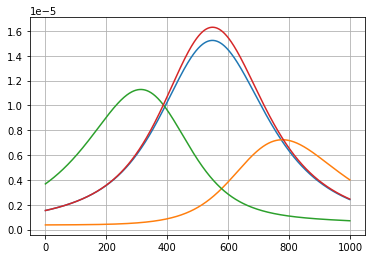

In [10]:
fig, ax = plt.subplots()
ax.plot(pwr_txL_to_rxL)
ax.plot(pwr_txL_to_rxR)
ax.plot(pwr_txR_to_rxL)
ax.plot(pwr_txR_to_rxR)
ax.grid()
plt.show()

share that among the 4 quadrants

In [11]:
shared_pwr_txL_to_rxL = quad_distribute_power(xRL_to_rxL, yRL_to_rxL, 0, f_QRX, pwr_txL_to_rxL)
shared_pwr_txL_to_rxR = quad_distribute_power(xRL_to_rxR, yRL_to_rxR, 0, f_QRX, pwr_txL_to_rxR)
shared_pwr_txR_to_rxL = quad_distribute_power(xRR_to_rxL, yRR_to_rxL, 0, f_QRX, pwr_txR_to_rxL)
shared_pwr_txR_to_rxR = quad_distribute_power(xRR_to_rxR, yRR_to_rxR, 0, f_QRX, pwr_txR_to_rxR)

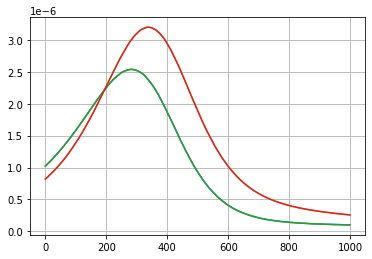

In [12]:
fig, ax = plt.subplots()
ax.plot(shared_pwr_txR_to_rxL[0])
ax.plot(shared_pwr_txR_to_rxL[1])
ax.plot(shared_pwr_txR_to_rxL[2])
ax.plot(shared_pwr_txR_to_rxL[3])
ax.grid()
plt.show()

**propagation delay**

speed_of_light defined inside

In [13]:
delay_txL_to_rxL = propagation_delay(xRL_to_rxL, yRL_to_rxL, 0)
delay_txL_to_rxR = propagation_delay(xRL_to_rxR, yRL_to_rxR, 0)
delay_txR_to_rxL = propagation_delay(xRR_to_rxL, yRR_to_rxL, 0)
delay_txR_to_rxR = propagation_delay(xRR_to_rxR, yRR_to_rxR, 0)

## Generate received signals from rx power values and noise factors

for simplicity, let's just assume a simple sine wave for each TX. 

Roberts wants 10-50 MHz with higher=better, but that's not feasible. Bechadergue ideally wants something on the order of MHz, and SonerColeri doesn't care, so let's stick to 1 MHz / 0.9 MHz, which is feasible

noiseless waveforms first

In [14]:
sig_dt      = 1.0*1e-7 #signal sampling period, seconds
txL_carrier = 1.0*1e6 # Hz
txR_carrier = 0.9*1e6 # Hz

rxLA_txL_peakAmps = shared_pwr_txL_to_rxL[0]*pd_snst
rxLC_txL_peakAmps = shared_pwr_txL_to_rxL[1]*pd_snst
rxLB_txL_peakAmps = shared_pwr_txL_to_rxL[2]*pd_snst
rxLD_txL_peakAmps = shared_pwr_txL_to_rxL[3]*pd_snst
rxRA_txL_peakAmps = shared_pwr_txL_to_rxR[0]*pd_snst
rxRC_txL_peakAmps = shared_pwr_txL_to_rxR[1]*pd_snst
rxRB_txL_peakAmps = shared_pwr_txL_to_rxR[2]*pd_snst
rxRD_txL_peakAmps = shared_pwr_txL_to_rxR[3]*pd_snst
rxLA_txR_peakAmps = shared_pwr_txR_to_rxL[0]*pd_snst
rxLC_txR_peakAmps = shared_pwr_txR_to_rxL[1]*pd_snst
rxLB_txR_peakAmps = shared_pwr_txR_to_rxL[2]*pd_snst
rxLD_txR_peakAmps = shared_pwr_txR_to_rxL[3]*pd_snst
rxRA_txR_peakAmps = shared_pwr_txR_to_rxR[0]*pd_snst
rxRC_txR_peakAmps = shared_pwr_txR_to_rxR[1]*pd_snst
rxRB_txR_peakAmps = shared_pwr_txR_to_rxR[2]*pd_snst
rxRD_txR_peakAmps = shared_pwr_txR_to_rxR[3]*pd_snst

veh_time = np.asarray( range(1,len(rxLA_txL_peakAmps)+1) )*veh_dt
sig_time = np.linspace(sig_dt, veh_time[-1], int(veh_time[-1]/sig_dt))

dLL_sigTime  = np.interp(sig_time, veh_time, delay_txL_to_rxL)
dLR_sigTime  = np.interp(sig_time, veh_time, delay_txL_to_rxR)
dRL_sigTime  = np.interp(sig_time, veh_time, delay_txR_to_rxL)
dRR_sigTime  = np.interp(sig_time, veh_time, delay_txR_to_rxR)

# /2 because sin is -1 to +1, which is 2 A_pp, we want nominal 1 A_pp 
rxLA_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLA_txL_peakAmps) 
rxLA_txL_wavAmps          = rxLA_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLL_sigTime))) / 2; 
rxLB_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLB_txL_peakAmps) 
rxLB_txL_wavAmps          = rxLB_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLL_sigTime))) / 2; 
rxLC_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLC_txL_peakAmps) 
rxLC_txL_wavAmps          = rxLC_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLL_sigTime))) / 2; 
rxLD_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLD_txL_peakAmps) 
rxLD_txL_wavAmps          = rxLD_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLL_sigTime))) / 2; 
rxRA_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRA_txL_peakAmps) 
rxRA_txL_wavAmps          = rxRA_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLR_sigTime))) / 2; 
rxRB_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRB_txL_peakAmps) 
rxRB_txL_wavAmps          = rxRB_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLR_sigTime))) / 2; 
rxRC_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRC_txL_peakAmps) 
rxRC_txL_wavAmps          = rxRC_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLR_sigTime))) / 2; 
rxRD_txL_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRD_txL_peakAmps) 
rxRD_txL_wavAmps          = rxRD_txL_peakAmps_sigTime*(np.sin(2*np.pi*txL_carrier*(sig_time - dLR_sigTime))) / 2; 

rxLA_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLA_txR_peakAmps) 
rxLA_txR_wavAmps          = rxLA_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRL_sigTime))) / 2; 
rxLB_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLB_txR_peakAmps) 
rxLB_txR_wavAmps          = rxLB_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRL_sigTime))) / 2; 
rxLC_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLC_txR_peakAmps) 
rxLC_txR_wavAmps          = rxLC_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRL_sigTime))) / 2; 
rxLD_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxLD_txR_peakAmps) 
rxLD_txR_wavAmps          = rxLD_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRL_sigTime))) / 2; 
rxRA_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRA_txR_peakAmps) 
rxRA_txR_wavAmps          = rxRA_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRR_sigTime))) / 2; 
rxRB_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRB_txR_peakAmps) 
rxRB_txR_wavAmps          = rxRB_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRR_sigTime))) / 2; 
rxRC_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRC_txR_peakAmps) 
rxRC_txR_wavAmps          = rxRC_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRR_sigTime))) / 2; 
rxRD_txR_peakAmps_sigTime = np.interp(sig_time, veh_time, rxRD_txR_peakAmps) 
rxRD_txR_wavAmps          = rxRD_txR_peakAmps_sigTime*(np.sin(2*np.pi*txR_carrier*(sig_time - dRR_sigTime))) / 2; 

In [15]:
# too much memory
del rxLA_txL_peakAmps_sigTime, rxLB_txL_peakAmps_sigTime, rxLC_txL_peakAmps_sigTime, rxLD_txL_peakAmps_sigTime 
del rxLA_txR_peakAmps_sigTime, rxLB_txR_peakAmps_sigTime, rxLC_txR_peakAmps_sigTime, rxLD_txR_peakAmps_sigTime 
del rxRA_txL_peakAmps_sigTime, rxRB_txL_peakAmps_sigTime, rxRC_txL_peakAmps_sigTime, rxRD_txL_peakAmps_sigTime 
del rxRA_txR_peakAmps_sigTime, rxRB_txR_peakAmps_sigTime, rxRC_txR_peakAmps_sigTime, rxRD_txR_peakAmps_sigTime
#del dLL_sigTime, dLR_sigTime, dRL_sigTime, dRR_sigTime

compute noise factors

In [16]:
# /16 due to C_T^2 in the thermal_factor2, each cell gets 1/4 of the total cap
thermal_and_bg_curr = rx_I_bg_factor*bg_current + temperature*(rx_thermal_factor1 + rx_thermal_factor2/16)

rxLA_total_pwr = shared_pwr_txR_to_rxL[0] + shared_pwr_txL_to_rxL[0] 
rxLB_total_pwr = shared_pwr_txR_to_rxL[1] + shared_pwr_txL_to_rxL[1] 
rxLC_total_pwr = shared_pwr_txR_to_rxL[2] + shared_pwr_txL_to_rxL[2] 
rxLD_total_pwr = shared_pwr_txR_to_rxL[3] + shared_pwr_txL_to_rxL[3]
rxRA_total_pwr = shared_pwr_txR_to_rxR[0] + shared_pwr_txL_to_rxR[0] 
rxRB_total_pwr = shared_pwr_txR_to_rxR[1] + shared_pwr_txL_to_rxR[1] 
rxRC_total_pwr = shared_pwr_txR_to_rxR[2] + shared_pwr_txL_to_rxR[2] 
rxRD_total_pwr = shared_pwr_txR_to_rxR[3] + shared_pwr_txL_to_rxR[3]

rxLA_noise_var = rx_P_rx_factor*rxLA_total_pwr + thermal_and_bg_curr; 
rxLB_noise_var = rx_P_rx_factor*rxLB_total_pwr + thermal_and_bg_curr; 
rxLC_noise_var = rx_P_rx_factor*rxLC_total_pwr + thermal_and_bg_curr; 
rxLD_noise_var = rx_P_rx_factor*rxLD_total_pwr + thermal_and_bg_curr; 
rxRA_noise_var = rx_P_rx_factor*rxRA_total_pwr + thermal_and_bg_curr; 
rxRB_noise_var = rx_P_rx_factor*rxRB_total_pwr + thermal_and_bg_curr; 
rxRC_noise_var = rx_P_rx_factor*rxRC_total_pwr + thermal_and_bg_curr; 
rxRD_noise_var = rx_P_rx_factor*rxRD_total_pwr + thermal_and_bg_curr; 

rxLA_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxLA_noise_var));
rxLB_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxLB_noise_var));
rxLC_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxLC_noise_var));
rxLD_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxLD_noise_var));
rxRA_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxRA_noise_var));
rxRB_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxRB_noise_var));
rxRC_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxRC_noise_var));
rxRD_noise_std = np.interp(sig_time, veh_time, np.sqrt(rxRD_noise_var));

add noise, get received signals at each quadrant in sig_time

note that the signals are separate for the two TX units -> this is because we assume that the two TX signals are kept at different frequency bands, thus, they can be easily extracted from the actual received signal via bandpass filtering. 

In [17]:
add_noise  = 1
numsamples = len(rxLA_txL_wavAmps)

rxLA_txL = (rxLA_txL_wavAmps + add_noise * rxLA_noise_std * np.random.randn(numsamples))*pd_gain;
rxLB_txL = (rxLB_txL_wavAmps + add_noise * rxLB_noise_std * np.random.randn(numsamples))*pd_gain;
rxLC_txL = (rxLC_txL_wavAmps + add_noise * rxLC_noise_std * np.random.randn(numsamples))*pd_gain;
rxLD_txL = (rxLD_txL_wavAmps + add_noise * rxLD_noise_std * np.random.randn(numsamples))*pd_gain;
rxRA_txL = (rxRA_txL_wavAmps + add_noise * rxRA_noise_std * np.random.randn(numsamples))*pd_gain;
rxRB_txL = (rxRB_txL_wavAmps + add_noise * rxRB_noise_std * np.random.randn(numsamples))*pd_gain;
rxRC_txL = (rxRC_txL_wavAmps + add_noise * rxRC_noise_std * np.random.randn(numsamples))*pd_gain;
rxRD_txL = (rxRD_txL_wavAmps + add_noise * rxRD_noise_std * np.random.randn(numsamples))*pd_gain;
rxLA_txR = (rxLA_txR_wavAmps + add_noise * rxLA_noise_std * np.random.randn(numsamples))*pd_gain;
rxLB_txR = (rxLB_txR_wavAmps + add_noise * rxLB_noise_std * np.random.randn(numsamples))*pd_gain;
rxLC_txR = (rxLC_txR_wavAmps + add_noise * rxLC_noise_std * np.random.randn(numsamples))*pd_gain;
rxLD_txR = (rxLD_txR_wavAmps + add_noise * rxLD_noise_std * np.random.randn(numsamples))*pd_gain;
rxRA_txR = (rxRA_txR_wavAmps + add_noise * rxRA_noise_std * np.random.randn(numsamples))*pd_gain;
rxRB_txR = (rxRB_txR_wavAmps + add_noise * rxRB_noise_std * np.random.randn(numsamples))*pd_gain;
rxRC_txR = (rxRC_txR_wavAmps + add_noise * rxRC_noise_std * np.random.randn(numsamples))*pd_gain;
rxRD_txR = (rxRD_txR_wavAmps + add_noise * rxRD_noise_std * np.random.randn(numsamples))*pd_gain;

In [18]:
del rxLA_txL_wavAmps, rxLB_txL_wavAmps, rxLC_txL_wavAmps, rxLD_txL_wavAmps
del rxRA_txL_wavAmps, rxRB_txL_wavAmps, rxRC_txL_wavAmps, rxRD_txL_wavAmps
del rxLA_txR_wavAmps, rxLB_txR_wavAmps, rxLC_txR_wavAmps, rxLD_txR_wavAmps
del rxRA_txR_wavAmps, rxRB_txR_wavAmps, rxRC_txR_wavAmps, rxRD_txR_wavAmps

del rxLA_noise_std, rxLB_noise_std, rxLC_noise_std, rxLD_noise_std
del rxRA_noise_std, rxRB_noise_std, rxRC_noise_std, rxRD_noise_std

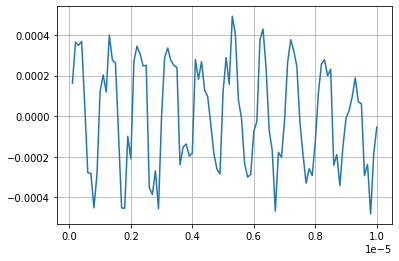

In [19]:
fig, ax = plt.subplots()
ax.plot(sig_time[0:100], rxLA_txL[0:100])
ax.grid()
plt.show()

## Run parameter measurement + positioning algo on the received signals

we assume that the VLC subsystem correctly decodes the signal, so we directly use the waveform here for power calc

In [20]:
wav_rxL_txL = np.sin(2*np.pi*txL_carrier*(sig_time - dLL_sigTime))
wav_rxL_txR = np.sin(2*np.pi*txR_carrier*(sig_time - dLR_sigTime))
wav_rxR_txL = np.sin(2*np.pi*txL_carrier*(sig_time - dRL_sigTime))
wav_rxR_txR = np.sin(2*np.pi*txR_carrier*(sig_time - dRR_sigTime))

now loop on the signals and compute parameter estimations

In [25]:
vlp_decimation_rate = 20 # make sure this divides len(veh_time)
vlp_rate = 1/(veh_dt*vlp_decimation_rate)
print("vlp rate:",vlp_rate, "Hz")

num_vlp_steps = int(len(veh_time)/vlp_decimation_rate)

vlp rate: 50.0 Hz


In [26]:
sig_numsamples = int(veh_dt/sig_dt)*vlp_decimation_rate
thd = 1e-5;

aoa_rxL_txL = np.zeros((num_vlp_steps))
aoa_rxL_txR = np.zeros((num_vlp_steps))
aoa_rxR_txL = np.zeros((num_vlp_steps))
aoa_rxR_txR = np.zeros((num_vlp_steps))

est_x_txL = np.zeros((num_vlp_steps))
est_x_txR = np.zeros((num_vlp_steps))
est_y_txL = np.zeros((num_vlp_steps))
est_y_txR = np.zeros((num_vlp_steps))

for i in range(0, num_vlp_steps):
    ii = range(i*sig_numsamples,(i+1)*sig_numsamples)
    
    aoa_rxL_txL[i] = aoa_measurement(rxLA_txL[ii], rxLB_txL[ii], rxLC_txL[ii], rxLD_txL[ii], wav_rxL_txL[ii], f_QRX, thd)
    aoa_rxR_txL[i] = aoa_measurement(rxRA_txL[ii], rxRB_txL[ii], rxRC_txL[ii], rxRD_txL[ii], wav_rxR_txL[ii], f_QRX, thd)
    aoa_rxL_txR[i] = aoa_measurement(rxLA_txR[ii], rxLB_txR[ii], rxLC_txR[ii], rxLD_txR[ii], wav_rxL_txR[ii], f_QRX, thd)
    aoa_rxR_txR[i] = aoa_measurement(rxRA_txR[ii], rxRB_txR[ii], rxRC_txR[ii], rxRD_txR[ii], wav_rxR_txR[ii], f_QRX, thd)
    
    est_x_txL[i] = L*(1 + np.sin(np.deg2rad(aoa_rxR_txL[i]))*np.cos(np.deg2rad(aoa_rxL_txL[i]))/np.sin(np.deg2rad(aoa_rxL_txL[i] - aoa_rxR_txL[i])));
    est_y_txL[i] = L*np.cos(np.deg2rad(aoa_rxR_txL[i]))*np.cos(np.deg2rad(aoa_rxL_txL[i]))/np.sin(np.deg2rad(aoa_rxL_txL[i] - aoa_rxR_txL[i]));
    est_x_txR[i] = L*(1 + np.sin(np.deg2rad(aoa_rxR_txR[i]))*np.cos(np.deg2rad(aoa_rxL_txR[i]))/np.sin(np.deg2rad(aoa_rxL_txR[i] - aoa_rxR_txR[i])));
    est_y_txR[i] = L*np.cos(np.deg2rad(aoa_rxR_txR[i]))*np.cos(np.deg2rad(aoa_rxL_txR[i]))/np.sin(np.deg2rad(aoa_rxL_txR[i] - aoa_rxR_txR[i]));

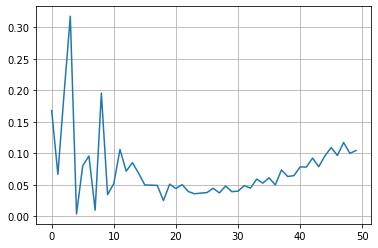

In [27]:
fig, ax = plt.subplots()
#ax.plot(est_x_txL, est_y_txL)
#ax.plot(xRL_to_rxL[::vlp_decimation_rate], yRL_to_rxL[::vlp_decimation_rate])
error_x = est_x_txL - xRL_to_rxL[::vlp_decimation_rate]
error_y = est_y_txL - yRL_to_rxL[::vlp_decimation_rate]
ax.plot(np.sqrt(error_x**2+error_y**2))
ax.grid()
plt.show()